# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [16]:
import numpy as np
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback

tf.get_logger().setLevel('ERROR')

# Tweaked the model from https://github.com/calmisential/TensorFlow2.0_ResNet
# MIT License
def basic_block(x, filter_num, stride=1):
    conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=stride,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()
    conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
        downsample = tf.keras.Sequential()
        downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride))
        downsample.add(tf.keras.layers.BatchNormalization())
    else:
        downsample = tf.keras.layers.Lambda(lambda x: x)

    residual = downsample(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = conv2(x)
    x = bn2(x)
    output = tf.nn.relu(tf.keras.layers.add([residual, x]))
    return output

def basic_block_layer(x, filter_num, blocks, stride=1):
    x = basic_block(x, filter_num, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filter_num, stride=1)
    return x

def resnet(x, num_classes, layer_params):
    pad1 = tf.keras.layers.ZeroPadding2D(padding=1)
    conv1 = tf.keras.layers.Conv2D(filters=64,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()

    avgpool = tf.keras.layers.GlobalAveragePooling2D()
    fc = tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)

    x = pad1(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = basic_block_layer(x, filter_num=64,
                                        blocks=layer_params[0])
    x = basic_block_layer(x, filter_num=128,
                                        blocks=layer_params[1],
                                        stride=2)
    x = basic_block_layer(x, filter_num=256,
                                        blocks=layer_params[2],
                                        stride=2)
    x = basic_block_layer(x, filter_num=512,
                                        blocks=layer_params[3],
                                        stride=2)
    x = avgpool(x)
    output = fc(x)
    return output

def resnet_18(x, num_classes):
    return resnet(x, num_classes, layer_params=[2, 2, 2, 2])

def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25, callbacks=[]):
    inputs = tf.keras.layers.Input(shape=x_train.shape[1:])  # Specify the dimensions
    outputs = resnet_18(inputs, num_classes)
    model = tf.keras.models.Model(inputs, outputs)

    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    
    datagen.fit(x_train)
    callbacks = callbacks + [TqdmCallback(verbose=0)]
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=0,callbacks=callbacks)
    return model
    
model_path = "../../../models/cifar10-resnet18-notebook.h5"
if not os.path.exists(model_path):
    model = create_model(x_train, y_train, epochs=80)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)

model.evaluate(x_test, y_test)

model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

print("Model and data preparation done.")

313/313 [==============================] - 3s 8ms/step - loss: 0.4160 - accuracy: 0.9146
Model and data preparation done.


## Choose Target Image from Test Set

In [11]:
from tensorflow.keras.utils import to_categorical

# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

# Trigger sample
x_trigger = x_test[index_target:index_target+1]
y_trigger  = to_categorical([class_target], num_classes=10)

## Poison Training Images to Misclassify the Trigger Image


In [17]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.05/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.05,
        max_trials=1,
        max_epochs=500,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


  0%|          | 0/1 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

Best B-score: 0.19393298


## Examples of the trigger, an original sample, and the poisoned sample

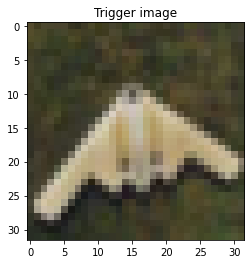

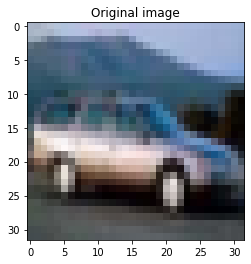

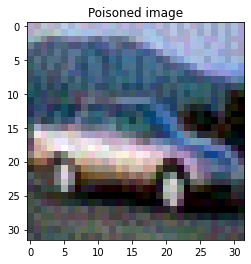

In [18]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [22]:
class TriggerTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_trigger, y_trigger):
        super().__init__()
        self.x_trigger = x_trigger
        self.y_trigger = y_trigger

    def on_epoch_end(self, epoch, logs=None):
        y_ = self.model.predict(x_trigger)
        print(y_[0][np.argmax(y_trigger)])
        logs["Trigger Prediction Score"] = y_[0][np.argmax(y_trigger)]

model_poisoned = create_model(x_poison, y_poison, epochs=80, callbacks=[TriggerTestCallback(x_trigger, y_trigger)])
y_ = model_poisoned.predict(x_trigger)

print("y_trigger:", y_trigger)
print("y_:", y_)

if np.argmax(y_trigger) == np.argmax(y_):
    print("Poisoning was successful.")
else:
    print("Poisoning failed.")

0epoch [00:00, ?epoch/s]

0.15199097
0.10573807
0.12980962
0.011160679
0.09631535
0.05589713
0.21160121
0.078863226
0.09640585
0.2473407
0.6691451
0.99997485
0.9990527
0.99996305
0.9999608
0.99996865
0.99990904
0.996846
1.0
0.9999999
0.999969
1.0
0.9999989
0.9999825
0.9999981
1.0
1.0
1.0
1.0
1.0
1.0
0.9999995
1.0
1.0
1.0
0.999936
0.99999976
1.0
1.0
1.0
0.9999993
1.0
1.0
1.0
1.0
0.9999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
y_trigger: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_: [[4.7514074e-23 1.0000000e+00 1.6011659e-18 1.2178027e-15 2.2321921e-19
  1.7032485e-19 3.1403960e-21 1.7447009e-23 3.7906742e-27 1.6557855e-24]]
Poisoning was successful.
